In [1]:
#connect the google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#pip install tensorflow-gpu

In [2]:
import tensorflow as tf
tf.__version__

'2.8.2'

In [58]:
pip install split-folders


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [59]:
import splitfolders

In [ ]:
data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/Colab Notebooks/spectrograms/data')

Found 8732 files belonging to 10 classes.


In [ ]:
data

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
#get another batch from the iterator
batch = data_iterator.next()

In [ ]:
len(batch)

2

In [ ]:
#images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [ ]:
batch[1]

array([4, 4, 5, 0, 5, 7, 3, 8, 5, 4, 2, 4, 0, 5, 4, 9, 6, 5, 3, 3, 8, 8,
       5, 5, 8, 0, 5, 9, 5, 0, 2, 6], dtype=int32)

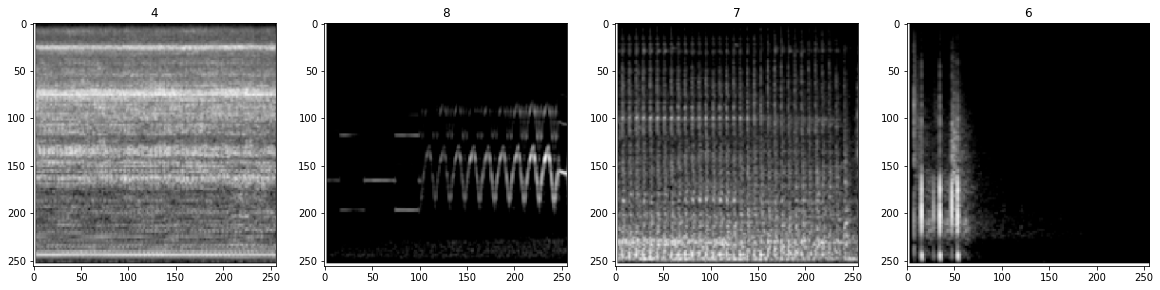

In [ ]:
fig,ax = plt.subplots(ncols=4,figsize=(20,20))
for idx,img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

In [ ]:
batch[0].shape

(32, 256, 256, 3)

In [ ]:
batch[0].min()

0.0

In [ ]:
batch[0].max()

255.0

## Split Data

### Split and save train,test,val

In [ ]:
input_folder = "/content/drive/MyDrive/Colab Notebooks/spectrograms/data"
output = "/content/drive/MyDrive/Colab Notebooks/spectrograms/data_split"

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.8, .1, .1)) # ratio of split are in order of train/val/test. You can change to whatever you want. For train/val sets only, you could do .75, .25 for example.


Copying files: 8732 files [03:19, 43.80 files/s]


### Load datasets

In [7]:
import matplotlib.pyplot as plt
import numpy as np

In [21]:
train = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/Colab Notebooks/UrbanSound8K/spectrograms/data_split/train')
test = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/Colab Notebooks/UrbanSound8K/spectrograms/data_split/test')
val = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/Colab Notebooks/UrbanSound8K/spectrograms/data_split/val')

Found 6985 files belonging to 10 classes.
Found 876 files belonging to 10 classes.
Found 871 files belonging to 10 classes.


In [ ]:
test

<MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
train.class_names

['air_conditioner',
 'car_horn',
 'children_playing',
 'dog_bark',
 'drilling',
 'engine_idling',
 'gun_shot',
 'jackhammer',
 'siren',
 'street_music']

In [ ]:
list([train.as_numpy_iterator(),train.class_names])

 ['air_conditioner',
  'car_horn',
  'children_playing',
  'dog_bark',
  'drilling',
  'engine_idling',
  'gun_shot',
  'jackhammer',
  'siren',
  'street_music']]

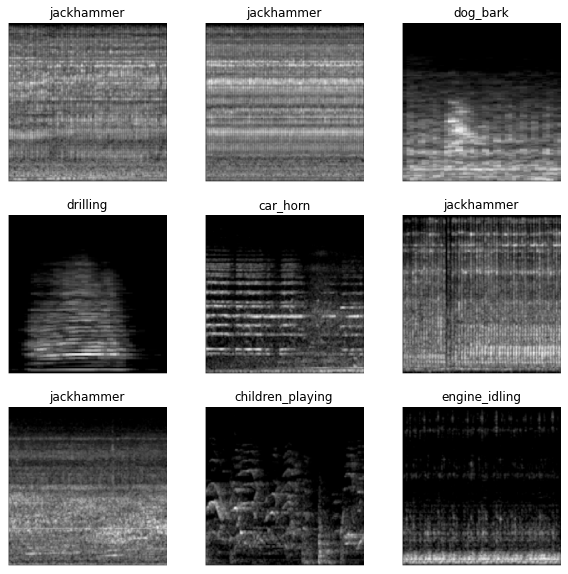

In [ ]:

class_names = train.class_names
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Normalization

In [22]:
normalization_layer = tf.keras.layers.Rescaling(1./255)


In [23]:
train = train.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(train))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [24]:
val = val.map(lambda x, y: (normalization_layer(x), y))
test = test.map(lambda x, y: (normalization_layer(x), y))


### Build Model

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense,Flatten
from tensorflow.keras.models import Sequential

In [25]:
num_classes = 10

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [26]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [28]:
results = model.fit(train,
                  validation_data=val,
                  epochs=5
                  )

Epoch 1/5
219/219 [==============================] - 339s 2s/step - loss: 2.1718 - accuracy: 0.1671 - val_loss: 1.8573 - val_accuracy: 0.3215
Epoch 2/5
219/219 [==============================] - 336s 2s/step - loss: 1.4087 - accuracy: 0.5127 - val_loss: 1.2078 - val_accuracy: 0.5936
Epoch 3/5
219/219 [==============================] - 357s 2s/step - loss: 1.0188 - accuracy: 0.6636 - val_loss: 1.1209 - val_accuracy: 0.6085
Epoch 4/5
219/219 [==============================] - 335s 2s/step - loss: 0.8203 - accuracy: 0.7354 - val_loss: 0.8343 - val_accuracy: 0.7256
Epoch 5/5
219/219 [==============================] - 337s 2s/step - loss: 0.6015 - accuracy: 0.8092 - val_loss: 0.7176 - val_accuracy: 0.7532


In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 32)       

### Plot Performance

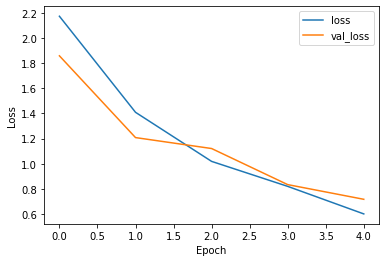

In [30]:
# Plot the the training loss
plt.plot(results.history["loss"],label="loss")

# Plot the the validation loss
plt.plot(results.history["val_loss"],label="val_loss")

# Name the x and y axises
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Put legend table
plt.legend()

# Show the plot
plt.show()

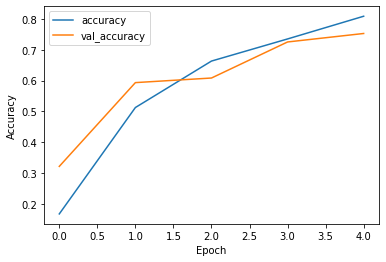

In [31]:
# Plot the the training accuracy
plt.plot(results.history["accuracy"], label="accuracy")

# Plot the the validation accuracy
plt.plot(results.history["val_accuracy"], label="val_accuracy")

# Name the x and y axises
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
# Put legend table
plt.legend()

# Show the plot
plt.show()

#### Evaluate the performance

In [32]:
model.evaluate(test)

28/28 [==============================] - 82s 2s/step - loss: 0.7262 - accuracy: 0.7717


[0.7261740565299988, 0.7716894745826721]

In [51]:
batch_test=test.as_numpy_iterator()
batch_test = batch_test.next()

In [52]:
batch_test

(array([[[[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [0.5586455 , 0.5586455 , 0.5586455 ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         [[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [0.58192235, 0.58192235, 0.58192235],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         [[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [0.58330274, 0.58330274, 0.58330274],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         ...,
 
         [[1.        , 1.        , 1.        ],
          [1.     

In [53]:
# Make prediction on the reshaped sample
prediction_result = model.predict(batch_test[0])
# Print the prediction result
prediction_result

array([[-4.8857226e+00, -2.3063169e+00,  5.3717098e+00,  1.3912865e+00,
        -1.0184354e+00,  1.3692145e+00, -6.5723834e+00, -1.8074728e+00,
         4.0512619e+00,  7.0971519e-01],
       [-2.7171180e+00, -2.8785639e+00, -2.4544601e+00, -3.2422616e+00,
        -4.8177730e-02,  1.1198845e+00, -2.1581986e+00,  2.8271739e+00,
        -1.5886295e+00, -2.0594796e-02],
       [ 5.6044378e+00, -9.5408624e-01, -7.3452169e-01, -4.1175523e-01,
        -5.6354105e-01,  1.2397237e+00, -2.3511548e+00, -5.2176803e-01,
        -9.7478271e-01, -2.3799153e-01],
       [ 1.5050212e-01, -1.1065099e+00,  1.4654021e-01, -7.4522063e-02,
        -1.9634539e+00,  3.9834833e-01,  5.3269196e+00, -3.7619793e+00,
        -9.9962187e-01, -9.9909538e-01],
       [-8.8941449e-01, -2.7576270e+00,  4.7316223e-01,  3.7344046e+00,
        -4.6725661e-01,  1.0551848e+00, -9.6076746e+00, -3.9006515e+00,
         9.9365177e+00,  3.3529351e+00],
       [ 2.1411343e+00, -6.6066641e-01,  2.6950202e+00,  8.5099357e-01,
   

In [56]:
batch_test[1]

array([2, 7, 0, 6, 8, 0, 9, 2, 7, 2, 5, 7, 3, 5, 1, 8, 9, 0, 8, 9, 5, 8,
       7, 3, 7, 0, 3, 4, 0, 3, 5, 1], dtype=int32)

In [38]:
# Find the predicted class
prediction_class = prediction_result.argmax()
# Find the prediction probability
prediction_probability = prediction_result.max()

In [39]:
# Print the results
print(f"This image belongs to class {prediction_class} with {prediction_probability} probability %")

This image belongs to class 193 with 17.399255752563477 probability %
